In [2]:
from random import randint
from tqdm import tqdm
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

In [ ]:
from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

In [3]:
len(dataset['train']['text'])

52400

In [4]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', padding=True)
model = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
text = "два"
encoded_input = tokenizer(text, return_tensors='pt', padding='max_length', max_length=512)
output = model(**encoded_input)

In [6]:
cnt = 0
sents = {}
bad_words = ['короче', 'типо', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
for bad_word in bad_words:
    sents[bad_word] = []
    
for sent in tqdm(dataset['train']['text']):
    words_in_sent = re.split('\W+', sent)
    for bad_word in bad_words:
        if bad_word in words_in_sent:
            cnt += 1
            sents[bad_word].append(sent)

100%|██████████| 52400/52400 [00:20<00:00, 2601.21it/s]


In [7]:
for bad_word in bad_words:
    print(bad_word, len(sents[bad_word]))

короче 116
типо 3
как бы 0
это самое 0
таки 5035
вот 7128
ну 1046
значит 2834


In [8]:
class HeadLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(HeadLinear, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [9]:
def insert_word(word: str, text: str) -> str:
    text_list = text.split(' ')
    pos = randint(0, len(text_list))
    text_list.insert(pos, word)
    result_string = " ".join(text_list)
    return result_string

In [10]:
def calc_labels(true_ids: torch.tensor, 
                inp_ids: torch.tensor, 
                mask_ids: set = {23279, 20413}) -> np.array:
    counter = 0
    indices = []
#     print(true_ids)
#     print(inp_ids)
    for i, x in enumerate(inp_ids):
        if x == true_ids[i - counter]:
            continue
        elif int(x) in mask_ids:
            counter += 1
            indices.append(i)
        else:
            print("DEBUG", i, counter, x, true_ids[i - counter], inp_ids[i - 10:i + 10], true_ids[i - 10:i + 10])
            print("DEBUG", true_ids.shape, inp_ids.shape)
            raise Exception("Bad token in calc_labels")
            
#     print(f"DEBUG: indices of bad_words: ", indices)
    
    labels = np.zeros(len(inp_ids), dtype=int)
    for ind in indices:
        labels[ind] = 1
    return labels

In [11]:
def test_single_sent(sentence: str):
#     token = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    bad_words = ['короче', 'типо', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
    set_bad_words_tokens = set()
    for bad_word in bad_words:
        set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
        
    source_tokenized_sent = tokenizer.encode(sentence)
    inserted_sent = insert_word('как бы', sentence)
    
    insert_tokenized_sent = tokenizer.encode(inserted_sent)
#     print("TEST: source_tokenized_sent", source_tokenized_sent)
#     print("TEST: insert_tokenized_sent", insert_tokenized_sent)
    labels = calc_labels(source_tokenized_sent, insert_tokenized_sent, set_bad_words_tokens)
#     print("TEST: labels", labels)
    
    inds = np.where(labels == 1)[0]
    
    for ind in np.flip(inds):
        insert_tokenized_sent.pop(int(ind))
    
    assert(insert_tokenized_sent == source_tokenized_sent)
    

def test_calc_labels(sentenes: list):
    for sent in sentenes:
        test_single_sent(sent)
    return

In [12]:
test_single_sent("привет мир привет мир")

In [13]:
for sent in tqdm(dataset['train']['text'][:100]):
    test_single_sent(sent)

100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


In [14]:
class TextDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, sentences):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        bad_words = ['короче', 'типо', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
        self.set_bad_words_tokens = set()
        for bad_word in bad_words:
            self.set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
            
            
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        
        self.sentences[idx] = self.sentences[idx][0:500]
        inserted_sentence = self.sentences[idx]
        
        for i in range(1):
            inserted_sentence = insert_word('короче', inserted_sentence)
        
        tokenized_src_data = tokenizer(self.sentences[idx], truncation=True, return_tensors='pt', padding='max_length', max_length=512)
        tokenized_ins_data = tokenizer(inserted_sentence, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
#         print(self.sentences[idx], inserted_sentence, sep='\n\n\n\n')
        
        tokenized_src_sent = tokenized_src_data['input_ids'][0]
        tokenized_ins_sent = tokenized_ins_data['input_ids'][0]
        
        labels = calc_labels(tokenized_src_sent, 
                             tokenized_ins_sent,
                             self.set_bad_words_tokens)
        
#         print(model(**tokenized_ins_data))
        return (tokenized_ins_data, labels)

In [15]:
train_dataset = TextDataset(dataset['train']['text'])
test_dataset = TextDataset(dataset['test']['text'])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [17]:
loss = torch.nn.L1Loss()
network = HeadLinear(768, 1)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

In [18]:
for X, y in train_loader:
    for key, value in X.items():
        X[key] = torch.squeeze(X[key], 1)
#     model(**X)
    break


In [19]:
def _epoch(network_bert, network_head, 
           loss, loader,
           optimizer=None,
           device = 'cpu',
           backward=True,
           ):
    losses = []
    accuracies = []
    cnt = 1
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
#         
        for key, value in X.items():
            X[key] = torch.squeeze(X[key], 1)
#         data = torch.squeeze(X[key], 1)
#         print("X: ", X)
#         print("data", data)
        y = y.view(-1)
#         print("y.shape:", y.shape)
        with torch.no_grad():
            model_output = network_bert(**X) 
#         print("model_output[0].shape: ", model_output[0].shape)
        word_embeddings = model_output[0].view(model_output[0].shape[0] * model_output[0].shape[1], -1)
#         print("word_embeddings.shape: ", word_embeddings.shape)
        network_head.zero_grad()
        prediction = network_head(word_embeddings)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
        cnt -= 1
        
        if cnt < 0:
            break
    return losses, accuracies

In [20]:
# _epoch(model, network, loss, train_loader, optimizer=optimizer)

In [21]:
def train(network_bert, network_head, train_loader, test_loader,
          epochs, optimizer, loss, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
#     loss = nn.NLLLoss()
#     optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network_bert = network_bert.to(device)
    network_head = network_head.to(device)
    try:
        for epoch in range(epochs):
            network.train()
#             _epoch(model, network, loss, train_loader, optimizer=optimizer)
            losses, accuracies = _epoch(network_bert, 
                                        network_head,
                                        loss,
                                        train_loader,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network_bert, 
                                        network_head,
                                        loss,
                                        test_loader,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


Epoch 9... (Train/Test) NLL: 0.529/0.554	Accuracy: 0.996/0.996


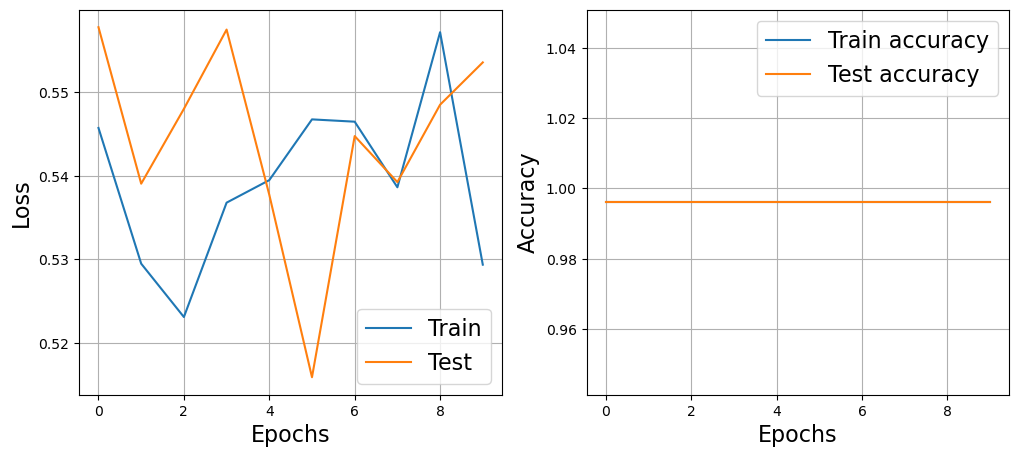

([0.5457170605659485,
  0.5294760763645172,
  0.5230911374092102,
  0.5367771983146667,
  0.5394734144210815,
  0.5467434227466583,
  0.5464676022529602,
  0.5386183261871338,
  0.5571770370006561,
  0.5293553471565247],
 [0.5577726364135742,
  0.5390483736991882,
  0.5480002462863922,
  0.5574911832809448,
  0.5377190113067627,
  0.5158862471580505,
  0.544744461774826,
  0.5392355024814606,
  0.5485010147094727,
  0.5535619258880615],
 [0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375],
 [0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375,
  0.99609375])

In [22]:
train(model, network, train_loader, test_loader, 10, optimizer, loss)